# COVID 19 - Compartmental Model

## Model

We define the following compartments:
- **$S$** is individuals who are at risks of Covid-19 infection
- **$I$** is infected individuals including asymptomatic and mild cases
- **$G$** is infected people who developed more severe cases of symptoms and required hospitalization
- **$P$** is those who recovered, and are seropositive and immune
- **$N$** is individuals who are recovered, immune but seronegative

We also introduce the attributes age ($a$), gender ($g$) and social activity group ($s$) differentiating individuals in a population.

Our model is formulated as a system of ordinary differential equations:

\begin{align*}
\tag{1}
& \dot{S}_{g,s,a} & = & -\lambda_{g,s,a}(t)S_{g,s,a} + (P_{g,s,a} + N_{g,s,a})/DI_g + \frac{1}{r}S_{g,s,a-1} - \frac{1}{r}S_{g,s,a} + &\\
&&& \frac{1}{R}\sum_{g,s}(S_{g,s,20} + I_{g,s,20} + G_{g,s,20} + P_{g,s,20} + N_{g,s,20}) \times &\\
&&& \delta_1(a)(\pi_1\delta_1(s) + \pi_2\delta_2(s) + \pi_3\delta_3(s) + \pi_4\delta_4(s)) &\\ \\
\tag{2}
& \dot{I}_{g,s,a}  & = &  \lambda_{g,s,a}(t)S_{g,s,a} - (1/WIP_g + 1/DAI_g)I_{g,s,a} + \frac{1}{r}I_{g,s,a-1}-\frac{1}{r}I_{g,s,a} &\\ \\
\tag{3}
& \dot{G}_{g,s,a}  & = &  I_{g,s,a}/WIP_g - G_{g,s,a}/DWT_g + \frac{1}{r}G_{g,s,a-1} - \frac{1}{r}G_{g,s,a} &\\ \\ 
\tag{4}
& \dot{P}_{g,s,a}  & = &  PSC_g(I_{g,s,a}/DAI_g + G_{g,s,a}/DWT_g) - P_{g,s,a}/DI_g + \frac{1}{r}P_{g,s,a-1} - \frac{1}{r}P_{g,s,a} &\\ \\
\tag{5}
& \dot{N}_{g,s,a}  & = &  (1-PSC_g)(I_{g,s,a}/DAI_g + G_{g,s,a}/DWT_g) - N_{g,s,a}/DI_g + \frac{1}{r}N_{g,s,a-1}-\frac{1}{r}N_{g,s,a} &\\ \\
\end{align*}

- $a$ : age - is 5-year band
- $g$ : gender - male = 0, female = 1
- $s$ : social intereaction category - active = 1, not active = 0

$
r = 5 * 365 = 1825 \\
R = 2 * 2 * 1825 = 7300
$

An important metric used to characterised the epidemic is $\mathcal{R}_0$ which is defined as:

$$
\mathcal{R}_0 = \tau \cdot \bar{c} \cdot d
$$

$\tau$ : the transmissibility (i.e., probability of infection given contact between a susceptible and infected individual)

$\bar{c}$ :  the average rate of contact between susceptible and infected individuals

$d$ : the duration of infectiousness

$\mathcal{R}_0$ is estimated to be between $2.76$ and $3.25$.

## Code

In [1]:
import pixiedust


Pixiedust database opened successfully


In [2]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline

STATES = ['S', 'I', 'G', 'P', 'N']

ages = np.arange(0, 101, 5, np.int32)

A_CATEGORIES = [str(t) for t in zip(ages, ages[1:])]
G_CATEGORIES = ["male", "female"]
S_CATEGORIES = ["high", "low"]

In [46]:
def intensity(t, g, s, a, S, I, G, P, N, beta, c):
    infectious_interactions = 0
    
    for g_1 in range(len(G_CATEGORIES)):
        for s_1 in range(len(S_CATEGORIES)):
            for a_1 in range(len(A_CATEGORIES)):
                opposite_group_sum = S[g_1, s_1, a_1] + \
                    I[g_1, s_1, a_1] + G[g_1, s_1, a_1] + \
                    P[g_1, s_1, a_1] + N[g_1, s_1, a_1]
                
                if not opposite_group_sum:
                    continue

                infectious_interactions += \
                    c[g, g_1, s, s_1, a, a_1] * I[g_1, s_1, a_1] / opposite_group_sum
    
    return beta[g] * infectious_interactions

def dS(t, g, s, a, S=None, I=None, G=None, P=None, N=None, beta=None, c=None, di=None, sip=None, r=None, **kwargs):
    dSdt = - intensity(t, g, s, a, S, I, G, P, N, beta, c) * S[g, s, a] + \
        (P[g, s, a] + N[g, s, a]) / di[g] - S[g, s, a] / r + int(bool(a)) * S[g, s, a-1] / r
    
    if a != 0:
        return dSdt
        
    R = 0
    inflow = 0
    for g in range(len(G_CATEGORIES)):
        for s in range(len(S_CATEGORIES)):
            R += 1
            inflow += (
                S[g, s, len(A_CATEGORIES)-1] +
                I[g, s, len(A_CATEGORIES)-1] +
                G[g, s, len(A_CATEGORIES)-1] +
                P[g, s, len(A_CATEGORIES)-1] +
                N[g, s, len(A_CATEGORIES)-1]
            ) * sip[s] / r
            
    return dSdt + inflow / R

def dI(t, g, s, a, S=None, I=None, G=None, P=None, N=None, beta=None, c=None, wip=None, dai=None, r=None, **kwargs):
    dIdt = intensity(t, g, s, a, S, I, G, P, N, beta, c) * S[g, s, a] - \
        (1/wip[g] + 1/dai[g]) * I[g, s, a] - I[g, s, a] / r + int(bool(a)) * I[g, s, a-1] / r
    
    return dIdt

def dG(t, g, s, a, I=None, G=None, wip=None, dwt=None, r=None, **kwargs):
    dGdt = I[g, s, a] / wip[g] - G[g, s, a] / dwt[g] - G[g, s, a] / r + int(bool(a)) * G[g, s, a-1] / r
    
    return dGdt

def dP(t, g, s, a, I=None, G=None, P=None, psc=None, dai=None, dwt=None, di=None, r=None, **kwargs):
    dPdt = psc[g] * (I[g, s, a] / dai[g] + G[g, s, a] / dwt[g]) - P[g, s, a] / di[g] - \
        P[g, s, a] / r + int(bool(a)) * P[g, s, a-1] / r
    
    return dPdt

def dN(t, g, s, a, I=None, G=None, N=None, psc=None, dai=None, dwt=None, di=None, r=None, **kwargs):
    dNdt = (1-psc[g]) * (I[g, s, a] / dai[g] + G[g, s, a] / dwt[g]) - \
        N[g, s ,a]/di[g] - N[g, s, a] / r + int(bool(a)) * N[g, s, a-1] / r
    
    return dNdt

DELTAS_FUNC = {
    "S": dS, "I": dI, "G": dG, "P": dP, "N": dN
}

def system(y, t, params):
    """System of ODEs
    
    Params:
        y (array) : the current state
        t (float) : the current time
        sip (array) : the proportion of people in each social interaction group (sum(sip) = 1)
        beta (array) : the transmission probabilities
        c (array) : mean per capita at which an individual interact with a new individual from g', s', a'
        di (array) : duration of immunity
        wip (array) : incubation period
        dai (array) : duration of asymptomatic infection symptoms
        dwt (array) : duration of treatment
        psc (array) : probability of becoming seropositive
        r (int) : the number of days for someone to move to the upper age category
    """
    params = {
        "sip" : params[0], 
        "beta": params[1],
        "c"   : params[2],
        "di"  : params[3], 
        "wip" : params[4], 
        "dai" : params[5], 
        "dwt" : params[6], 
        "psc" : params[7], 
        "r"   : params[8]
    }
    
    states_ = y.reshape((len(STATES), len(G_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES)))
    states = {}
    for i, state in enumerate(STATES):
        states[state] = states_[i]
        
    deltas = {
        state: np.zeros((len(G_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES))) 
        for state in STATES
    }

    for a in range(len(A_CATEGORIES)-1, -1, -1):
        for g in range(len(G_CATEGORIES)-1, -1, -1):
            for s in range(len(S_CATEGORIES)-1, -1, -1):
                for state in STATES:
                    deltas[state][g, s, a] = DELTAS_FUNC[state](t, g, s, a, **states, **params)
                    
    for state in STATES:
        deltas[state] = deltas[state].flatten()
        
    ret = np.concatenate(tuple(deltas[state] for state in STATES))
    return ret


In [5]:
def generate_initial_state(n=100, infected_ratio=0.5, seed=123):
    """Generate a random initial state
    
    Params:
        n (int): the population size
        infected_ratio (float): the ratio of people infected in the population
        seed (int): the random seed to use
    """
    np.random.seed(seed)
    
    ages = np.random.randint(len(A_CATEGORIES), size=n)
    genders = np.random.randint(len(G_CATEGORIES), size=n)
    social_interactions = np.random.randint(len(S_CATEGORIES), size=n)
    
    initial_states = {
        state: np.zeros((len(G_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES)))
        for state in STATES
    }
    
    for i, (a, g, s) in enumerate(zip(ages, genders, social_interactions)):
        if i < int(n*infected_ratio):
            initial_states["I"][g, s, a] += 1
        else:
            initial_states["S"][g, s, a] += 1
            
    for state in STATES:
        initial_states[state] = initial_states[state].flatten()
        
    return np.concatenate(tuple(initial_states[state] for state in STATES))

In [6]:
def generate_social_interaction_matrix():
    return np.ones((
        len(G_CATEGORIES), len(G_CATEGORIES), 
        len(S_CATEGORIES), len(S_CATEGORIES),
        len(A_CATEGORIES), len(A_CATEGORIES)
    ))

In [7]:
state0 = generate_initial_state()

c = generate_social_interaction_matrix()

args = ((
    [0.8, 0.2], # sip
    [0.4, 0.2], # beta
    c, # c
    [2, 2], # di
    [7, 7], # wip
    [3, 3], # dai
    [14, 14], # dwt
    [0.5, 0.5], # psc
    1825, # r
),)


t = np.linspace(0, 100, 101)
sol = odeint(system, state0, t, args=args)

In [8]:
def build_history(sol):
    """Reconstruct the history from the output of the ODE solver
    
    Params:
        sol (array): the output of the ODE solver
        
    Returns:
        hist (array): the array of shape (len(t), len(G), len(S), len(A))
    """
    hists = {
        state: [] for state in STATES
    }
    
    for t, states_t in enumerate(sol):
        for state, vals in zip(STATES, np.array_split(states_t, len(STATES))):
            hists[state].append(
                vals.reshape((len(G_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES)))
            )
            
    return {s : np.array(h) for s, h in hists.items()}

hists = build_history(sol)

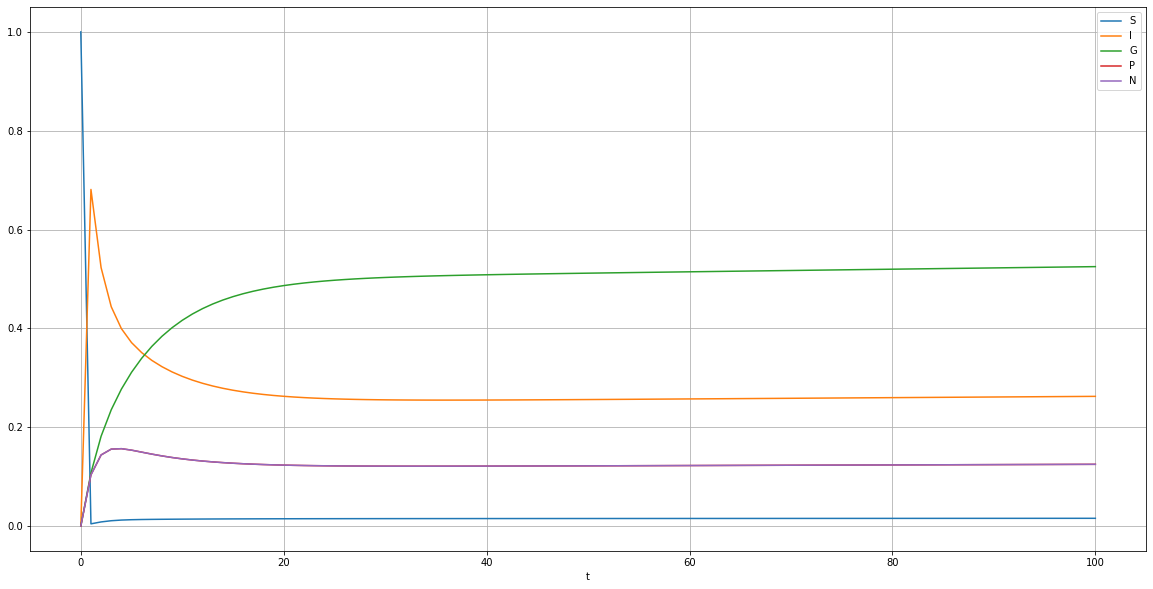

In [9]:
G = G_CATEGORIES.index("male")
S = S_CATEGORIES.index("high")
A = A_CATEGORIES.index("(25, 30)")

plt.figure(figsize=(20,10))

plt.plot(t, hists["S"][:, G, S, A], label='S')
plt.plot(t, hists["I"][:, G, S, A], label='I')
plt.plot(t, hists["G"][:, G, S, A], label='G')
plt.plot(t, hists["P"][:, G, S, A], label='P')
plt.plot(t, hists["N"][:, G, S, A], label='N')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()